### Dataset prepare

In [14]:
import pandas as pd
import seaborn as sns
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [15]:
def read_dataset(file_path):
    df = pd.read_excel(file_path, engine='openpyxl')
    split_df = df.iloc[:, 0].str.split(',', expand=True)
    df = pd.concat([split_df, df.iloc[:, 1:]], axis=1)
    df.set_index(0, inplace=True)
    df.replace('', np.nan, inplace=True)
    float_columns = [1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    df[float_columns] = df[float_columns].astype(float)
    df[2] = df[2].astype(int)
    df[3] = pd.to_datetime(df[3])
    if len(df.columns) == 16:
        df.columns = [i for i in range(15)] + ['target']
        df['target'] = df['target'].astype(float)
    else:
        df.columns = [i for i in range(15)]
    return df

train_df = read_dataset('Train.xlsm')
test_df = read_dataset('Test.xlsm')
train_df = train_df.dropna(subset=['target'])
train_df

/tmp/ipykernel_114250/3483946888.py:4: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df = pd.concat([split_df, df.iloc[:, 1:]], axis=1)
/tmp/ipykernel_114250/3483946888.py:4: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df = pd.concat([split_df, df.iloc[:, 1:]], axis=1)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,target
0,,,,,,,,,,,,,,,,
0,3.750398,5,2023-06-15 03:30:00,12903.833250,64.505981,2.429055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.623
1,4.005138,5,2023-06-15 05:30:00,16171.536150,66.194287,2.481289,0.064445,7.014456,4.593825,0.001492,1.421696,63.55895,0.231434,0.097160,NaN,0.749
2,1.138600,5,2023-06-15 08:30:00,1733.193000,28.557797,1.078523,0.060213,7.017953,5.006483,0.001901,1.424601,53.58850,0.287297,0.095316,NaN,0.567
3,1.616377,4,2023-06-16 00:30:00,8358.641357,55.669162,1.387313,0.067553,7.358407,4.699417,0.001742,1.522439,56.76965,0.297938,0.104719,NaN,0.868
4,3.858570,3,2023-06-16 03:30:00,13771.152234,64.979572,2.402651,0.068745,7.511205,4.730615,0.002402,1.406540,58.54170,0.369762,0.115043,NaN,0.714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,1.541226,5,2023-09-02 05:30:00,16832.363058,59.738111,1.315700,0.035728,3.889718,5.927809,0.007788,1.352219,56.53480,0.026602,0.064896,1.103390,0.539
611,1.633076,1,2023-09-02 08:30:00,1638.324702,62.146119,1.387070,0.032118,3.888994,6.398580,0.001320,1.269232,55.29650,0.114387,0.044616,1.070049,0.413
612,1.416566,4,2023-09-02 12:30:00,8474.165994,60.084859,1.185423,0.036856,3.837705,5.761320,0.001320,1.391910,55.76620,0.175571,0.037610,1.083395,0.462


##### Предобработка фичей: нормализация, обработка выбрасов и стандартизация

In [16]:
def fill_miss(df):
    fill_map = {
        0: 'median',
        3: 'mean',
        4: 'median',
        5: 'median',
        6: 'median',
        7: 'median',
        8: 'median',
        9: 'median',
        10: 'mean',
        11: 'mean',
        12: 'median',
        13: 'median',
        14: 'median',
    }
    for feature_index, method in fill_map.items():
        if method == 'median':
            df[feature_index].fillna(df[feature_index].median(), inplace=True)
        elif method == 'mean':
            df[feature_index].fillna(df[feature_index].mean(), inplace=True)

    return df

train_df = fill_miss(train_df)
train_df

/tmp/ipykernel_114250/1540220978.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[feature_index].fillna(df[feature_index].median(), inplace=True)
/tmp/ipykernel_114250/1540220978.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,target
0,,,,,,,,,,,,,,,,
0,3.750398,5,2023-06-15 03:30:00,12903.833250,64.505981,2.429055,0.080919,7.981222,4.850663,0.002680,1.525098,53.655175,0.369762,0.170905,1.379641,0.623
1,4.005138,5,2023-06-15 05:30:00,16171.536150,66.194287,2.481289,0.064445,7.014456,4.593825,0.001492,1.421696,63.558950,0.231434,0.097160,1.379641,0.749
2,1.138600,5,2023-06-15 08:30:00,1733.193000,28.557797,1.078523,0.060213,7.017953,5.006483,0.001901,1.424601,53.588500,0.287297,0.095316,1.379641,0.567
3,1.616377,4,2023-06-16 00:30:00,8358.641357,55.669162,1.387313,0.067553,7.358407,4.699417,0.001742,1.522439,56.769650,0.297938,0.104719,1.379641,0.868
4,3.858570,3,2023-06-16 03:30:00,13771.152234,64.979572,2.402651,0.068745,7.511205,4.730615,0.002402,1.406540,58.541700,0.369762,0.115043,1.379641,0.714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,1.541226,5,2023-09-02 05:30:00,16832.363058,59.738111,1.315700,0.035728,3.889718,5.927809,0.007788,1.352219,56.534800,0.026602,0.064896,1.103390,0.539
611,1.633076,1,2023-09-02 08:30:00,1638.324702,62.146119,1.387070,0.032118,3.888994,6.398580,0.001320,1.269232,55.296500,0.114387,0.044616,1.070049,0.413
612,1.416566,4,2023-09-02 12:30:00,8474.165994,60.084859,1.185423,0.036856,3.837705,5.761320,0.001320,1.391910,55.766200,0.175571,0.037610,1.083395,0.462


In [17]:
def handle_outliers(df):
    for feature in [0, 4, 5, 7, 12, 13, 14]:
        upper_limit = df[feature].quantile(0.99)
        df[feature] = np.where(df[feature] > upper_limit, upper_limit, df[feature])
    return df
train_df = handle_outliers(train_df)
test_df = handle_outliers(test_df)
train_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,target
0,,,,,,,,,,,,,,,,
0,3.750398,5,2023-06-15 03:30:00,12903.833250,64.505981,2.429055,0.080919,7.981222,4.850663,0.002680,1.525098,53.655175,0.369762,0.170905,1.379641,0.623
1,4.005138,5,2023-06-15 05:30:00,16171.536150,66.194287,2.481289,0.064445,7.014456,4.593825,0.001492,1.421696,63.558950,0.231434,0.097160,1.379641,0.749
2,1.138600,5,2023-06-15 08:30:00,1733.193000,28.557797,1.078523,0.060213,7.017953,5.006483,0.001901,1.424601,53.588500,0.287297,0.095316,1.379641,0.567
3,1.616377,4,2023-06-16 00:30:00,8358.641357,55.669162,1.387313,0.067553,7.358407,4.699417,0.001742,1.522439,56.769650,0.297938,0.104719,1.379641,0.868
4,3.858570,3,2023-06-16 03:30:00,13771.152234,64.979572,2.402651,0.068745,7.511205,4.730615,0.002402,1.406540,58.541700,0.369762,0.115043,1.379641,0.714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,1.541226,5,2023-09-02 05:30:00,16832.363058,59.738111,1.315700,0.035728,3.889718,5.927809,0.007788,1.352219,56.534800,0.026602,0.064896,1.103390,0.539
611,1.633076,1,2023-09-02 08:30:00,1638.324702,62.146119,1.387070,0.032118,3.888994,6.398580,0.001320,1.269232,55.296500,0.114387,0.044616,1.070049,0.413
612,1.416566,4,2023-09-02 12:30:00,8474.165994,60.084859,1.185423,0.036856,3.837705,5.761320,0.001320,1.391910,55.766200,0.175571,0.037610,1.083395,0.462


In [18]:
scaler = StandardScaler()
train_df.iloc[:, [3, 6, 8, 10, 11]] = scaler.fit_transform(train_df.iloc[:, [3, 6, 8, 10, 11]])
joblib.dump(scaler, 'scaler.pkl')
scaler = joblib.load('scaler.pkl')
test_df.iloc[:, [3, 6, 8, 10, 11]] = scaler.transform(test_df.iloc[:, [3, 6, 8, 10, 11]])
train_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,target
0,,,,,,,,,,,,,,,,
0,3.750398,5,2023-06-15 03:30:00,0.502481,64.505981,2.429055,-0.334468,7.981222,-0.087364,0.002680,-2.786937e-15,0.000000,0.369762,0.170905,1.379641,0.623
1,4.005138,5,2023-06-15 05:30:00,1.071755,66.194287,2.481289,-0.951778,7.014456,-0.552718,0.001492,-1.297826e+00,1.093168,0.231434,0.097160,1.379641,0.749
2,1.138600,5,2023-06-15 08:30:00,-1.443579,28.557797,1.078523,-1.110360,7.017953,0.194958,0.001901,-1.261372e+00,-0.007360,0.287297,0.095316,1.379641,0.567
3,1.616377,4,2023-06-16 00:30:00,-0.289346,55.669162,1.387313,-0.835319,7.358407,-0.361401,0.001742,-3.337860e-02,0.343772,0.297938,0.104719,1.379641,0.868
4,3.858570,3,2023-06-16 03:30:00,0.653579,64.979572,2.402651,-0.790659,7.511205,-0.304874,0.002402,-1.488056e+00,0.539369,0.369762,0.115043,1.379641,0.714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,1.541226,5,2023-09-02 05:30:00,1.186879,59.738111,1.315700,-2.027849,3.889718,1.864268,0.007788,-2.169854e+00,0.317850,0.026602,0.064896,1.103390,0.539
611,1.633076,1,2023-09-02 08:30:00,-1.460107,62.146119,1.387070,-2.163156,3.888994,2.717238,0.001320,-3.211440e+00,0.181168,0.114387,0.044616,1.070049,0.413
612,1.416566,4,2023-09-02 12:30:00,-0.269220,60.084859,1.185423,-1.985614,3.837705,1.562614,0.001320,-1.671681e+00,0.233013,0.175571,0.037610,1.083395,0.462


##### Анализ автокорреляции и частичной автокорреляции 

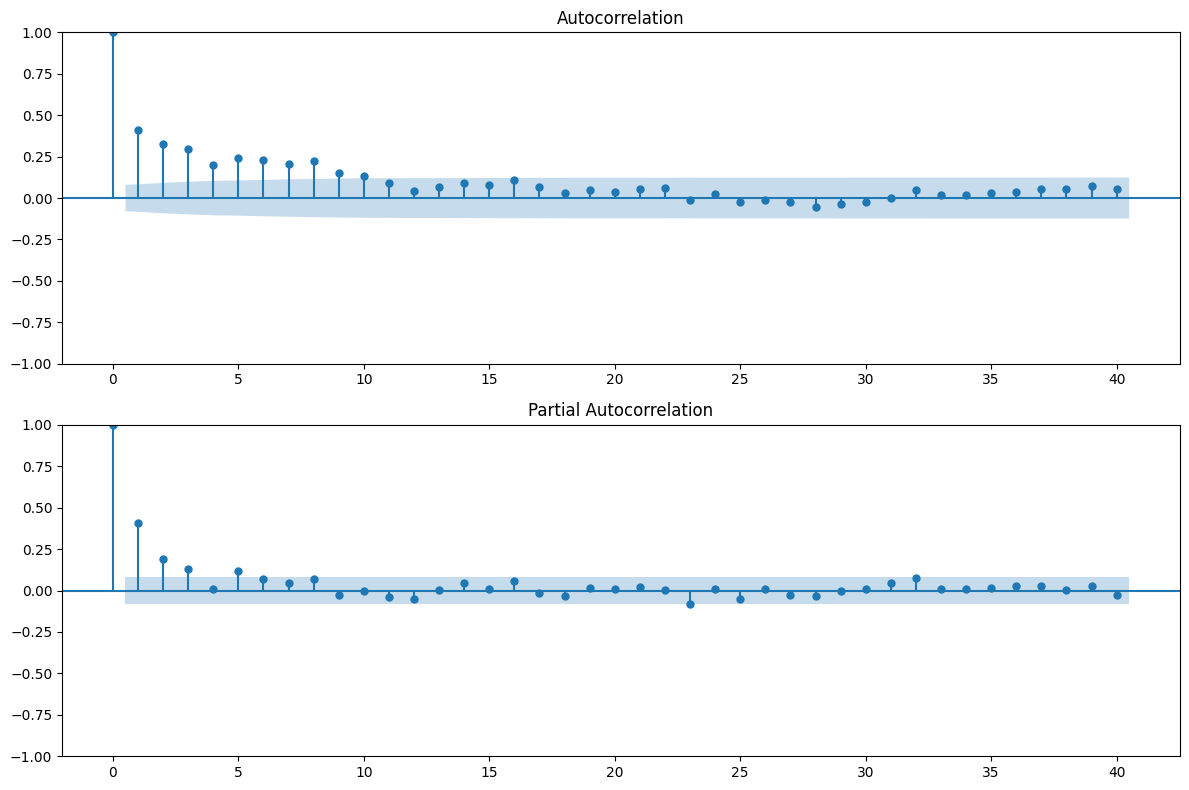

In [19]:
time_series = pd.Series(train_df['target'])

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(time_series, lags=40, ax=ax[0])
plot_pacf(time_series, lags=40, ax=ax[1])

plt.tight_layout()
plt.show()

##### Оценка корреляции

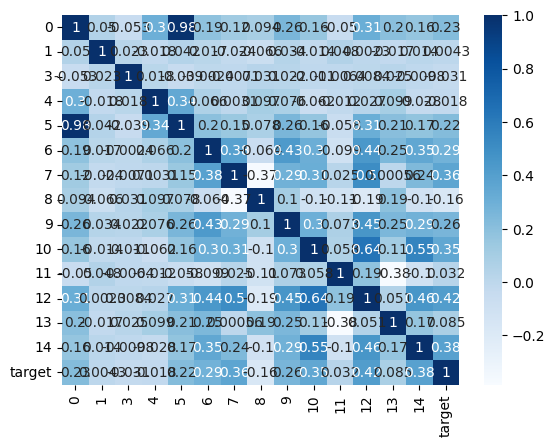

In [20]:
corr_matrix = train_df.corr()
corr = train_df.drop([ 2], axis=1).corr()
sns.heatmap(corr, cmap="Blues", annot=True)
plt.show()

##### PSI индекс

PSI for 0: inf


/tmp/ipykernel_114250/2964054498.py:17: RuntimeWarning: divide by zero encountered in divide
  psi_value = np.sum((expected_proportions - actual_proportions) * np.log(expected_proportions / actual_proportions))


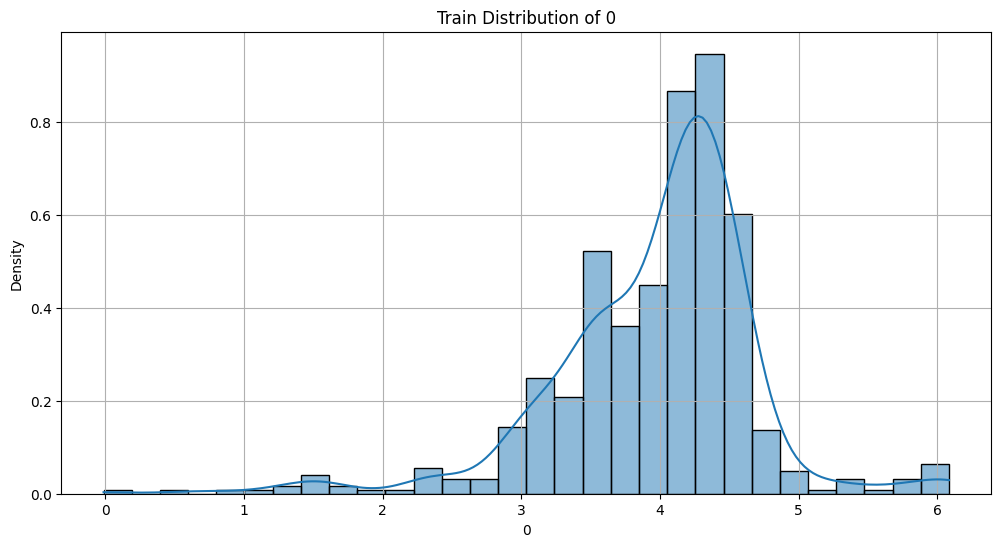

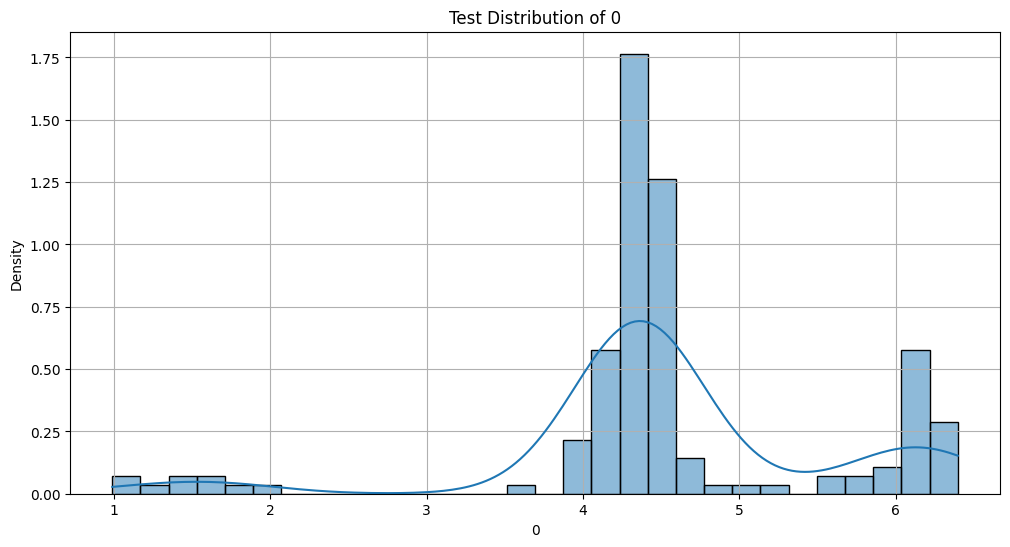

PSI for 1: nan


/tmp/ipykernel_114250/2964054498.py:17: RuntimeWarning: invalid value encountered in divide
  psi_value = np.sum((expected_proportions - actual_proportions) * np.log(expected_proportions / actual_proportions))


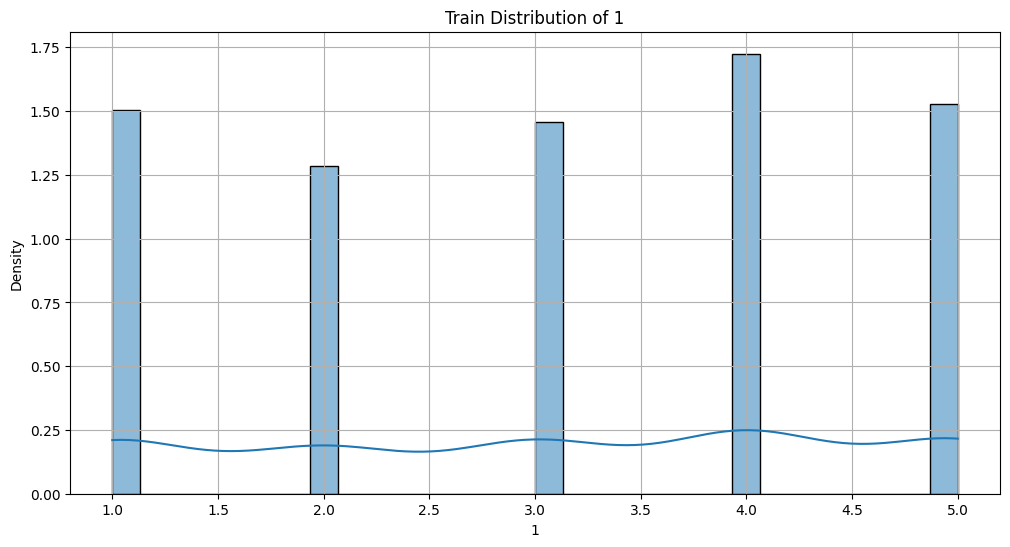

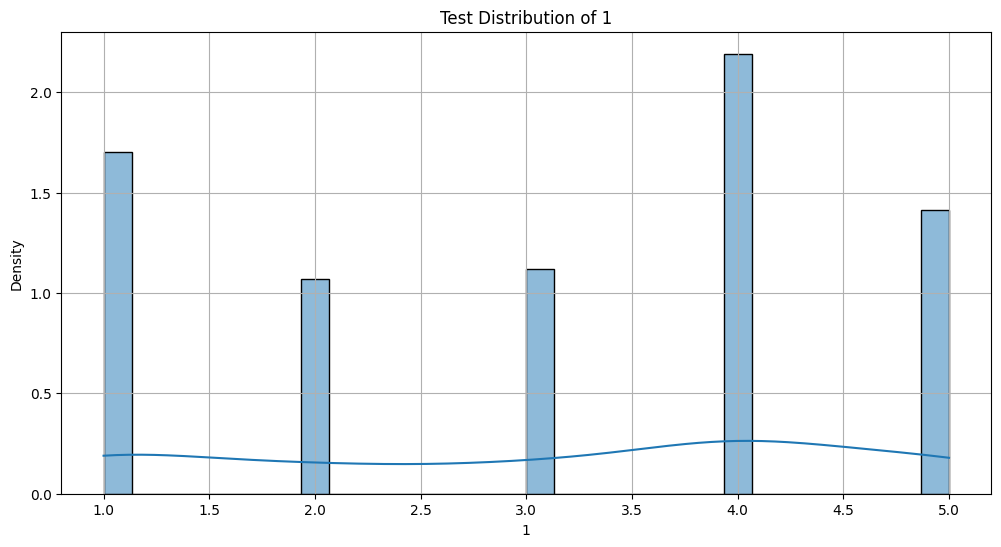

PSI for 3: inf


/tmp/ipykernel_114250/2964054498.py:17: RuntimeWarning: divide by zero encountered in divide
  psi_value = np.sum((expected_proportions - actual_proportions) * np.log(expected_proportions / actual_proportions))


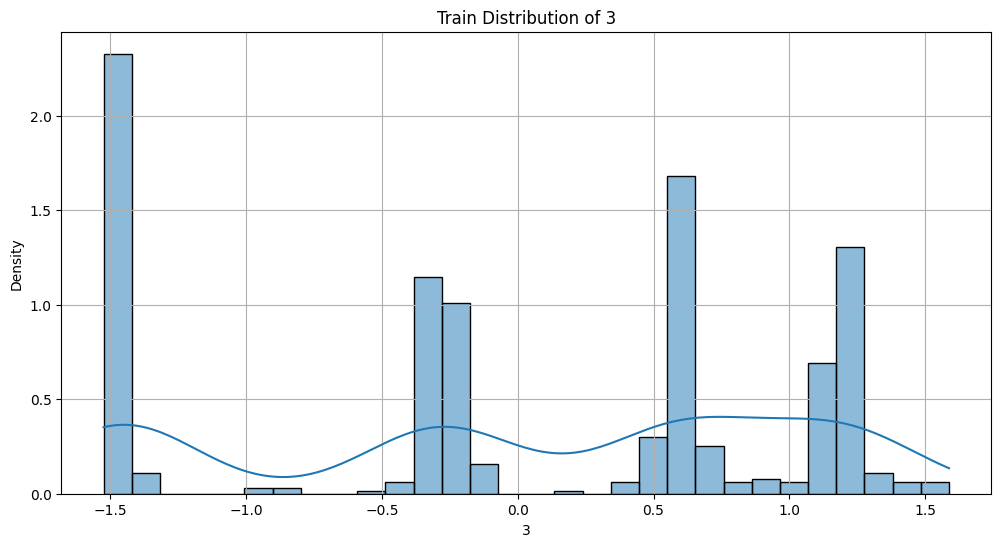

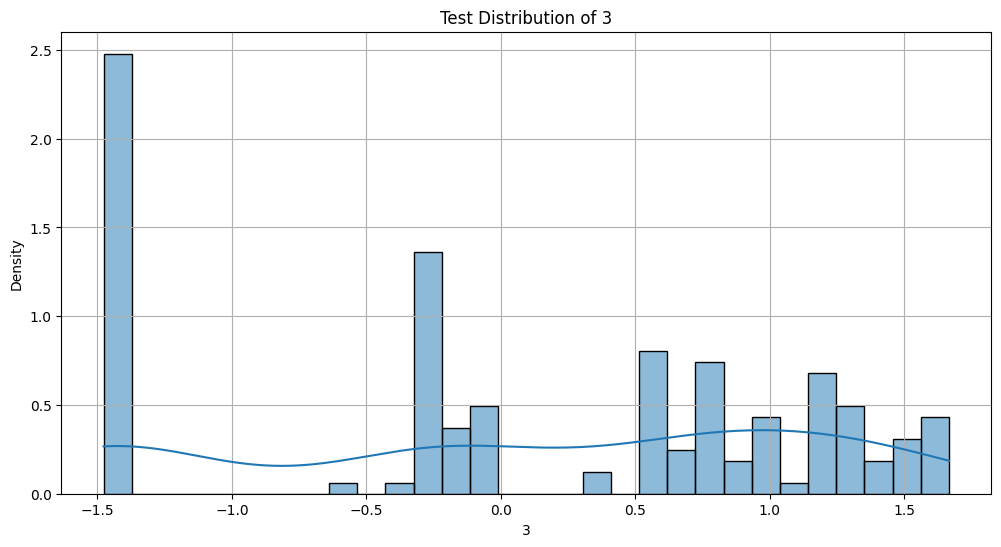

PSI for 4: nan


/tmp/ipykernel_114250/2964054498.py:17: RuntimeWarning: divide by zero encountered in divide
  psi_value = np.sum((expected_proportions - actual_proportions) * np.log(expected_proportions / actual_proportions))
/tmp/ipykernel_114250/2964054498.py:17: RuntimeWarning: invalid value encountered in divide
  psi_value = np.sum((expected_proportions - actual_proportions) * np.log(expected_proportions / actual_proportions))


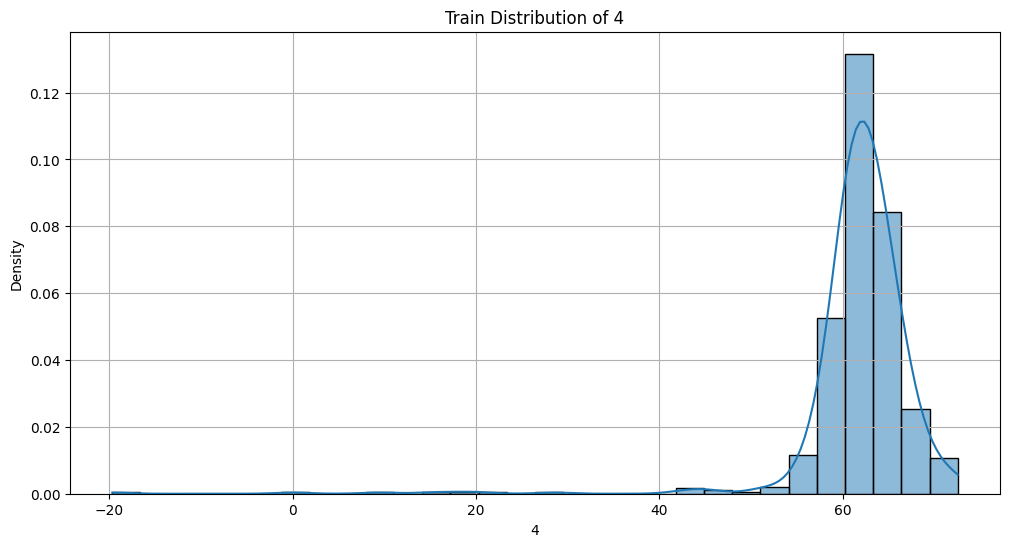

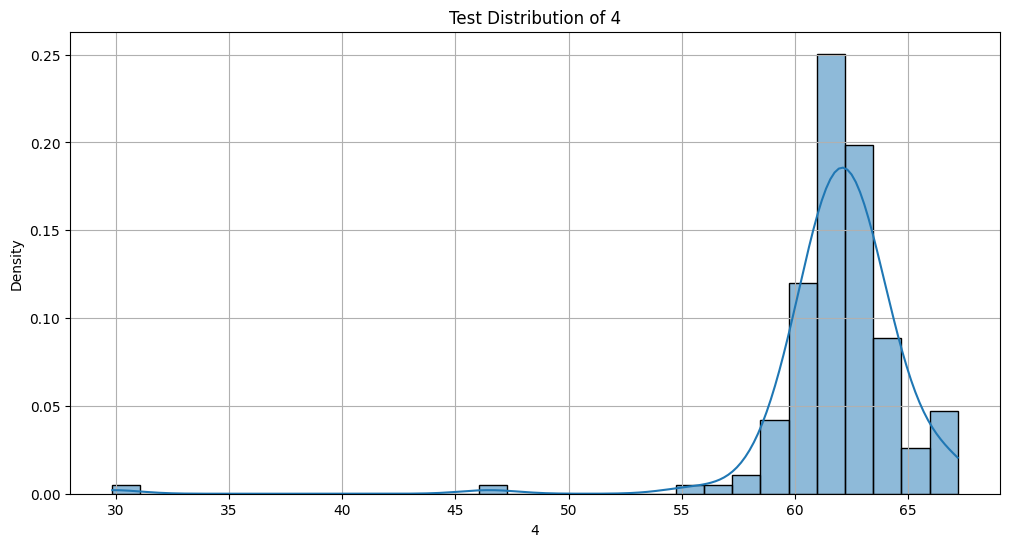

/tmp/ipykernel_114250/2964054498.py:17: RuntimeWarning: divide by zero encountered in divide
  psi_value = np.sum((expected_proportions - actual_proportions) * np.log(expected_proportions / actual_proportions))
/tmp/ipykernel_114250/2964054498.py:17: RuntimeWarning: invalid value encountered in divide
  psi_value = np.sum((expected_proportions - actual_proportions) * np.log(expected_proportions / actual_proportions))


PSI for 5: nan


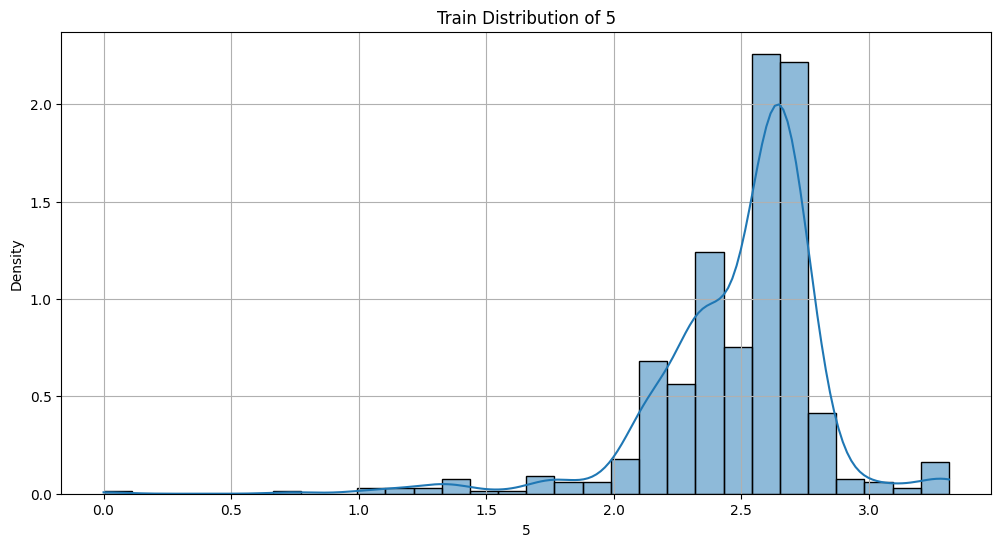

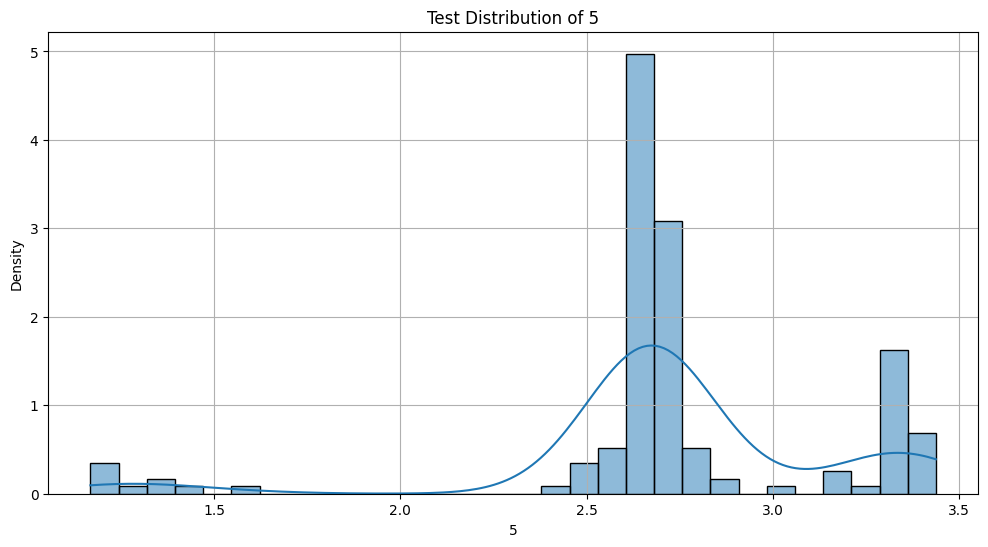

PSI for 6: 0.6519


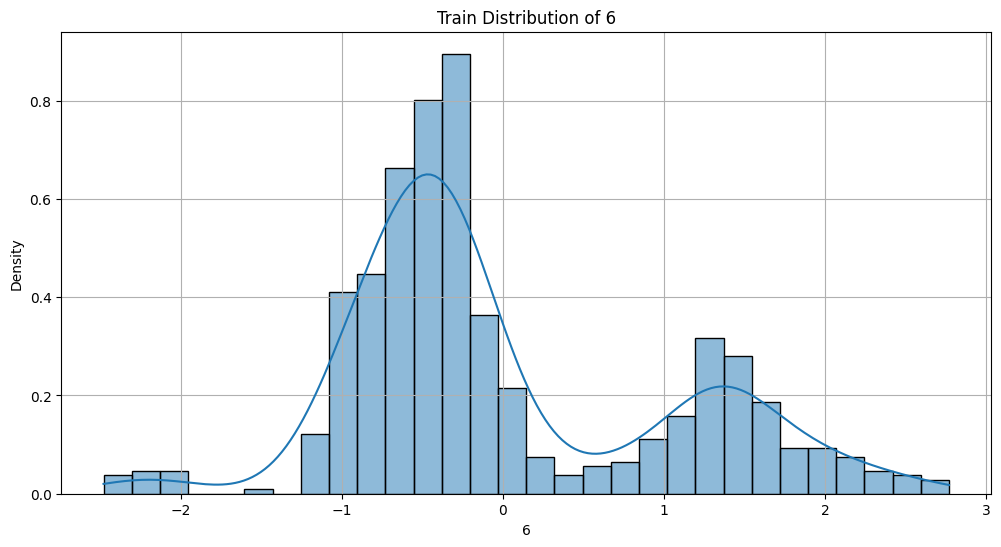

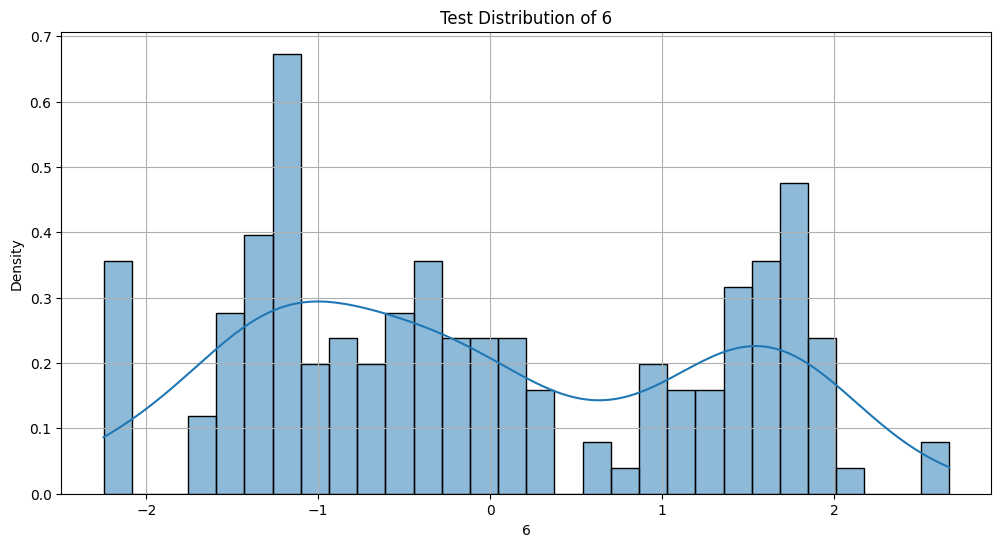

PSI for 7: nan


/tmp/ipykernel_114250/2964054498.py:17: RuntimeWarning: divide by zero encountered in divide
  psi_value = np.sum((expected_proportions - actual_proportions) * np.log(expected_proportions / actual_proportions))
/tmp/ipykernel_114250/2964054498.py:17: RuntimeWarning: invalid value encountered in divide
  psi_value = np.sum((expected_proportions - actual_proportions) * np.log(expected_proportions / actual_proportions))


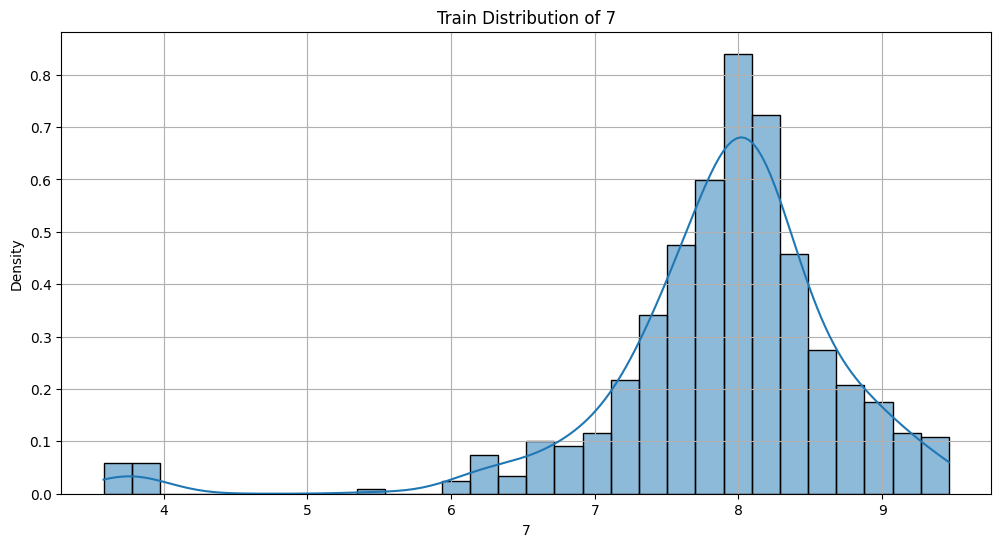

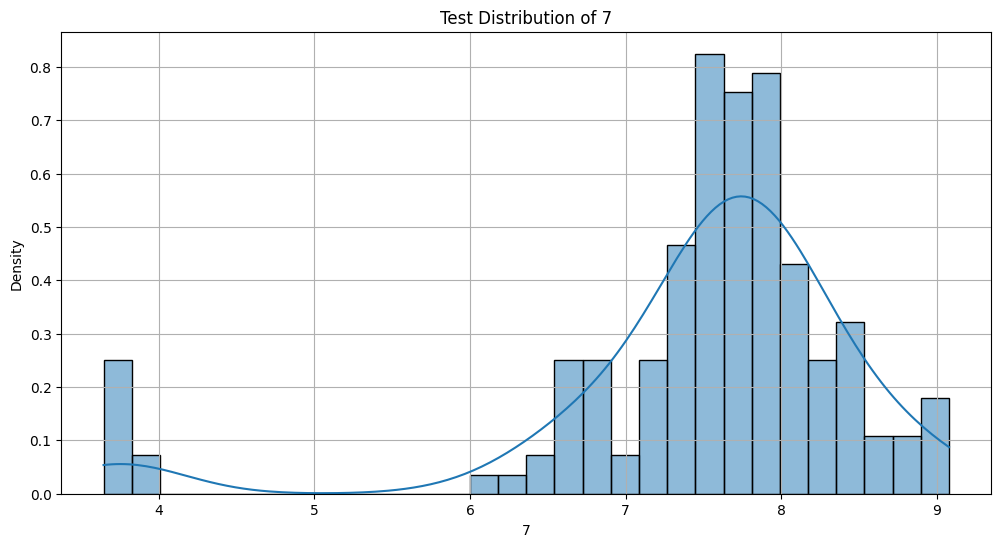

PSI for 8: inf


/tmp/ipykernel_114250/2964054498.py:17: RuntimeWarning: divide by zero encountered in divide
  psi_value = np.sum((expected_proportions - actual_proportions) * np.log(expected_proportions / actual_proportions))


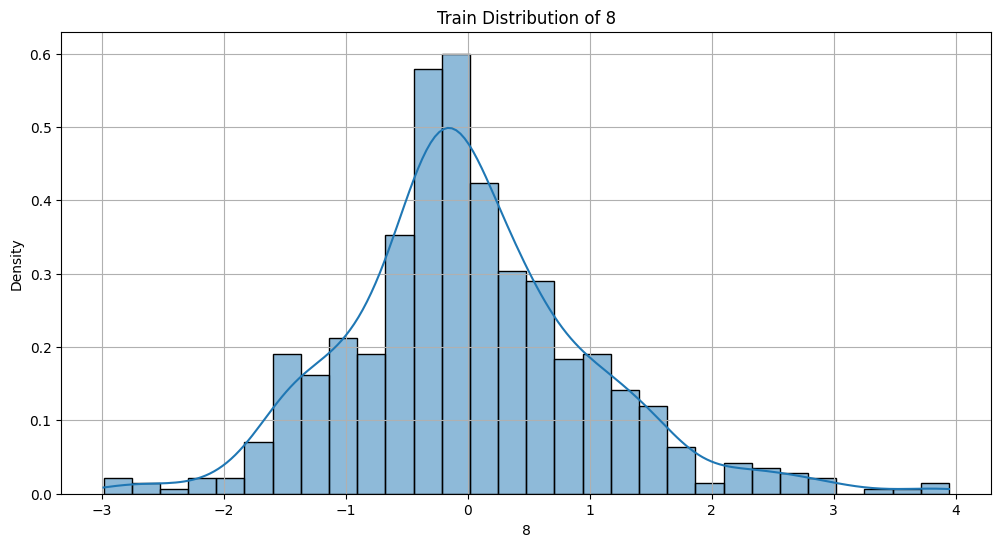

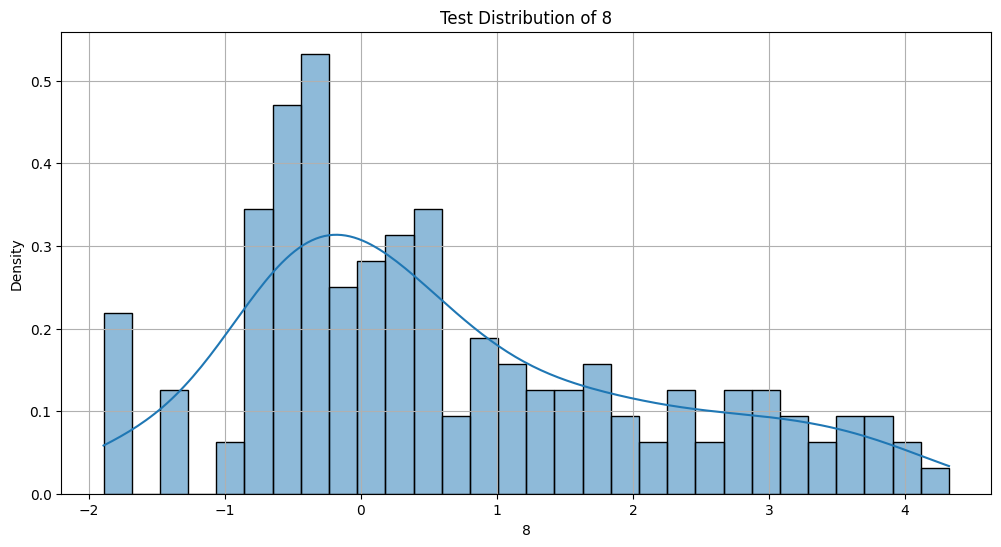

PSI for 9: nan


/tmp/ipykernel_114250/2964054498.py:17: RuntimeWarning: divide by zero encountered in divide
  psi_value = np.sum((expected_proportions - actual_proportions) * np.log(expected_proportions / actual_proportions))
/tmp/ipykernel_114250/2964054498.py:17: RuntimeWarning: invalid value encountered in divide
  psi_value = np.sum((expected_proportions - actual_proportions) * np.log(expected_proportions / actual_proportions))
/tmp/ipykernel_114250/2964054498.py:17: RuntimeWarning: divide by zero encountered in log
  psi_value = np.sum((expected_proportions - actual_proportions) * np.log(expected_proportions / actual_proportions))


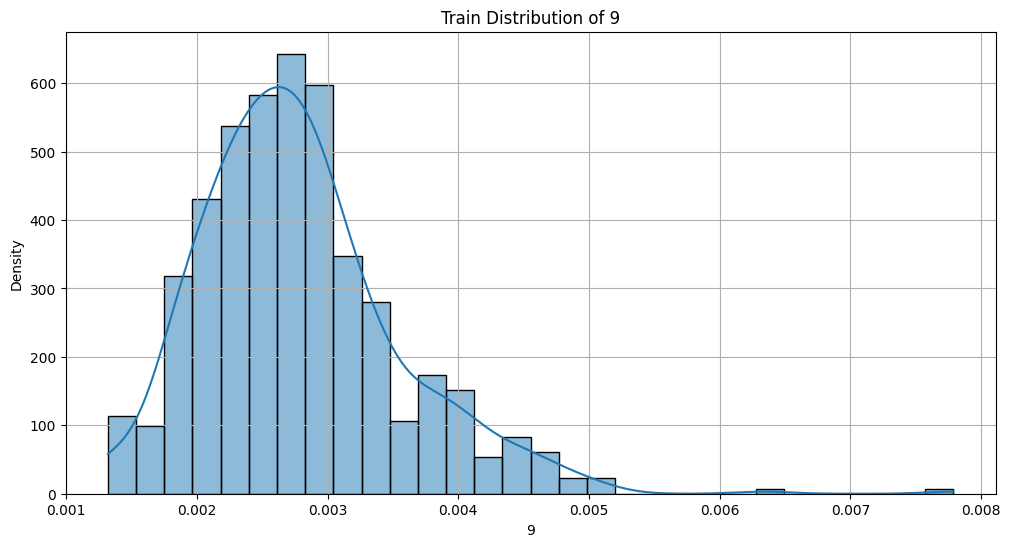

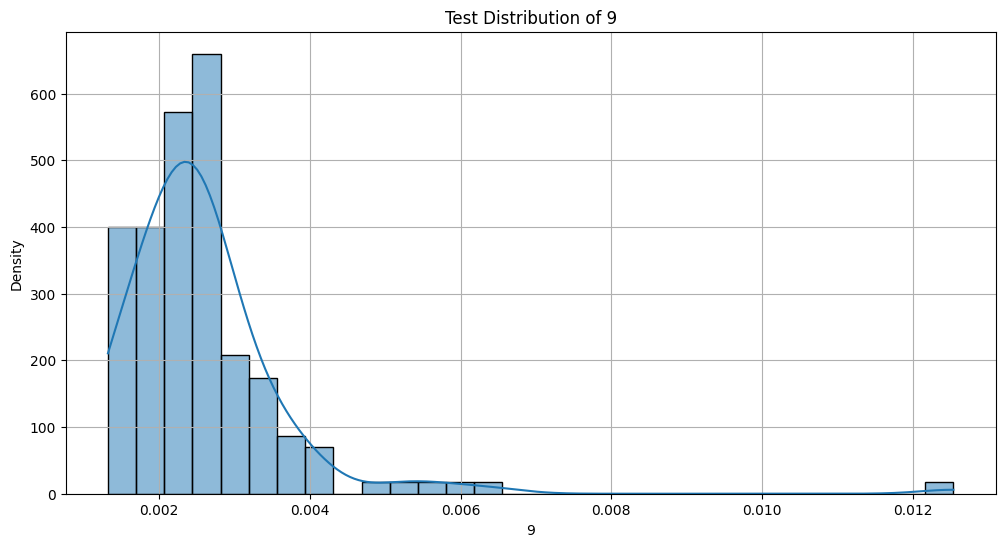

PSI for 10: nan


/tmp/ipykernel_114250/2964054498.py:17: RuntimeWarning: divide by zero encountered in divide
  psi_value = np.sum((expected_proportions - actual_proportions) * np.log(expected_proportions / actual_proportions))
/tmp/ipykernel_114250/2964054498.py:17: RuntimeWarning: invalid value encountered in divide
  psi_value = np.sum((expected_proportions - actual_proportions) * np.log(expected_proportions / actual_proportions))


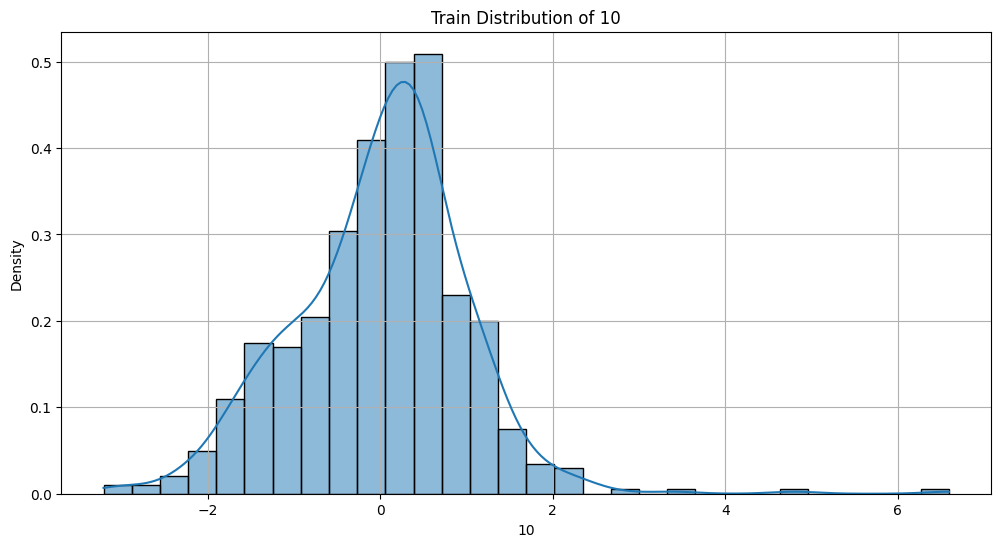

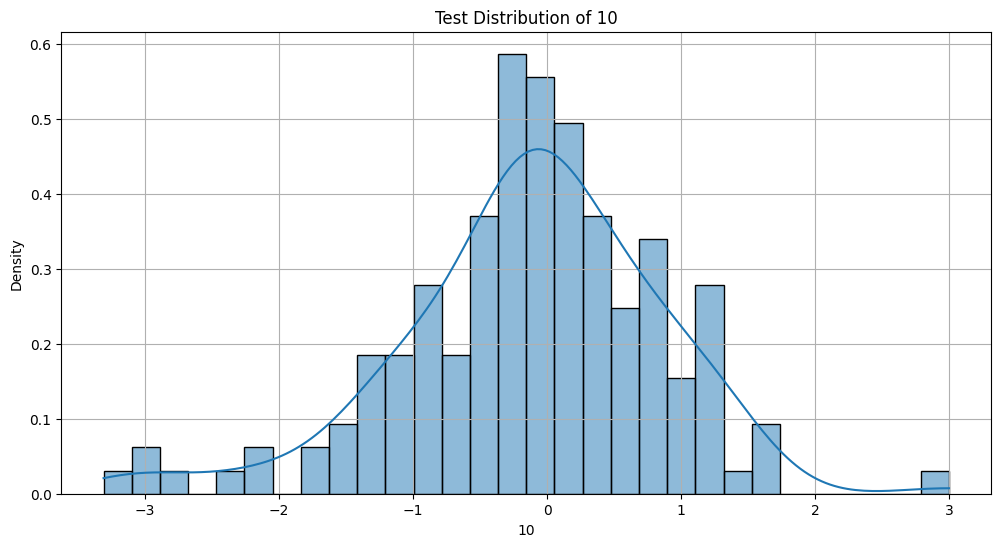

PSI for 11: inf


/tmp/ipykernel_114250/2964054498.py:17: RuntimeWarning: divide by zero encountered in divide
  psi_value = np.sum((expected_proportions - actual_proportions) * np.log(expected_proportions / actual_proportions))


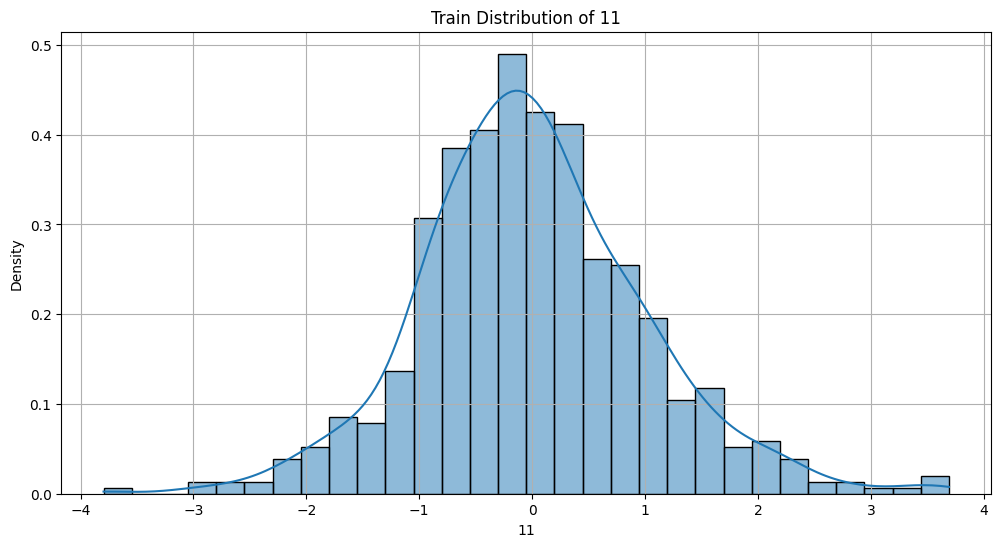

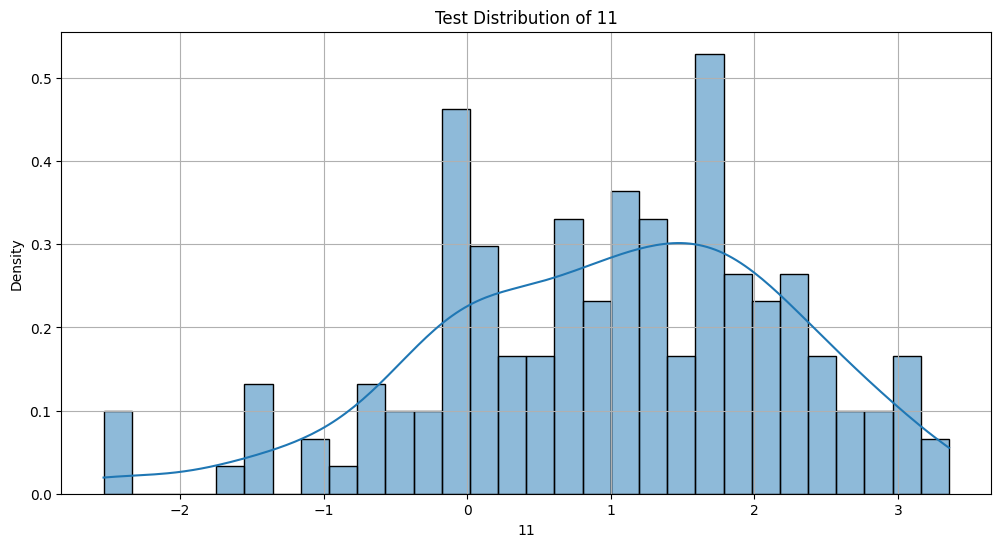

/tmp/ipykernel_114250/2964054498.py:17: RuntimeWarning: divide by zero encountered in divide
  psi_value = np.sum((expected_proportions - actual_proportions) * np.log(expected_proportions / actual_proportions))


PSI for 12: inf


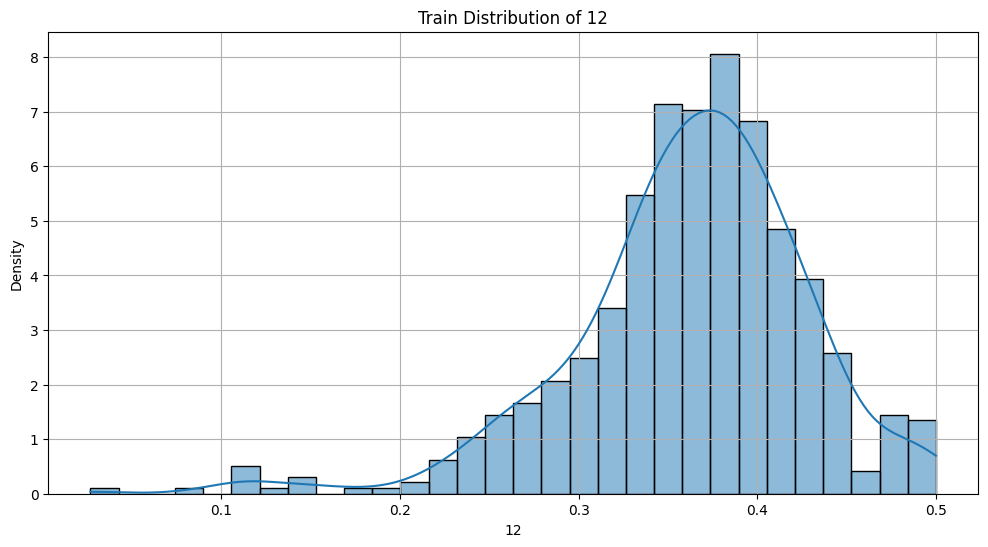

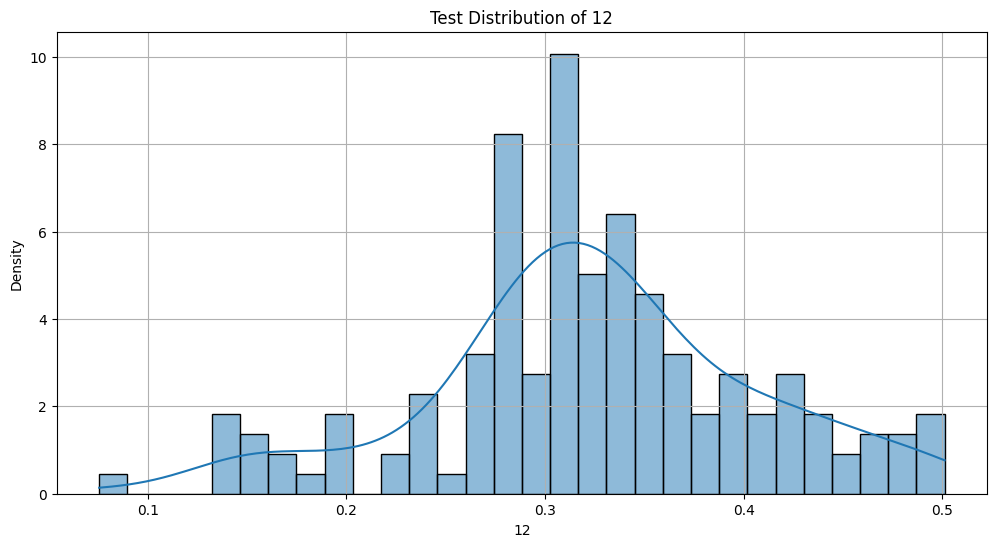

PSI for 13: inf


/tmp/ipykernel_114250/2964054498.py:17: RuntimeWarning: divide by zero encountered in divide
  psi_value = np.sum((expected_proportions - actual_proportions) * np.log(expected_proportions / actual_proportions))


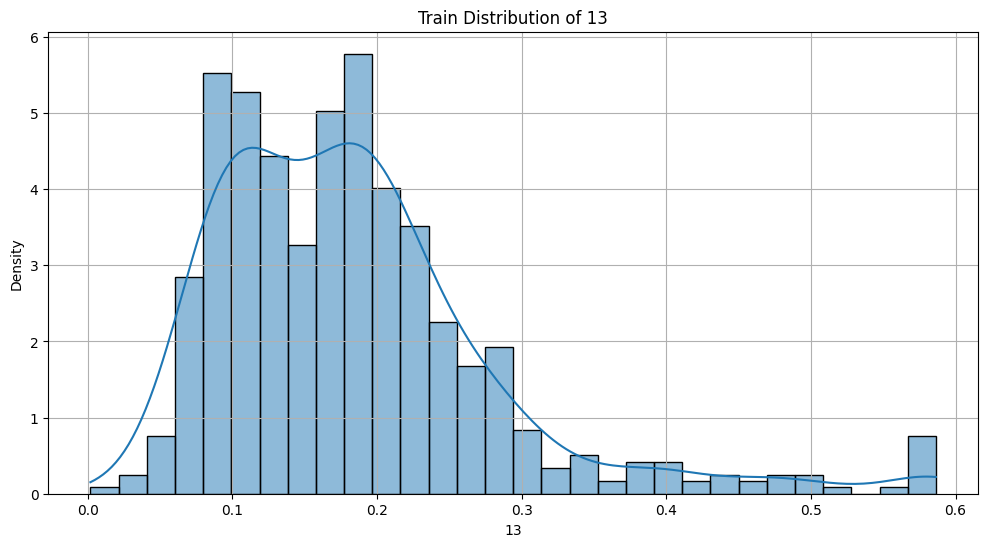

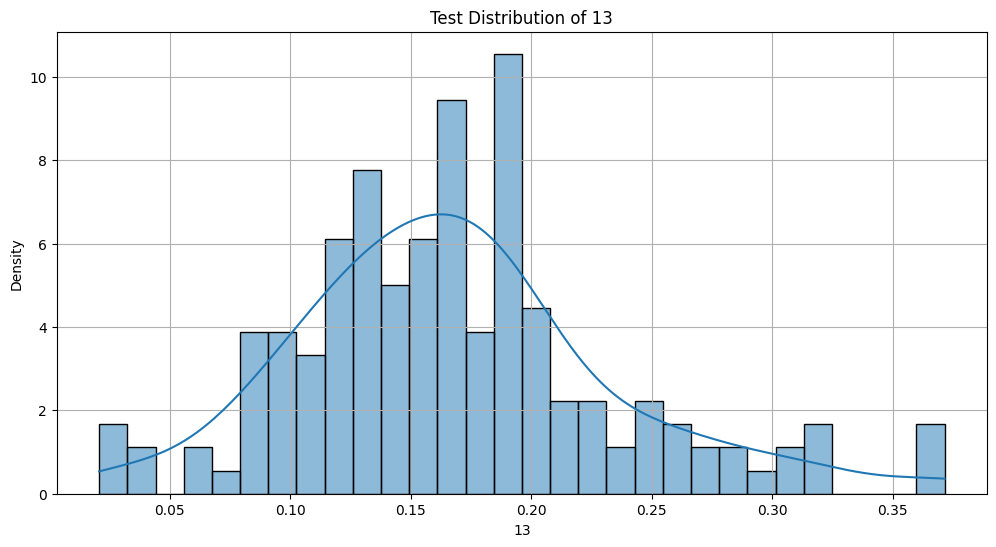

PSI for 14: inf


/tmp/ipykernel_114250/2964054498.py:17: RuntimeWarning: divide by zero encountered in divide
  psi_value = np.sum((expected_proportions - actual_proportions) * np.log(expected_proportions / actual_proportions))


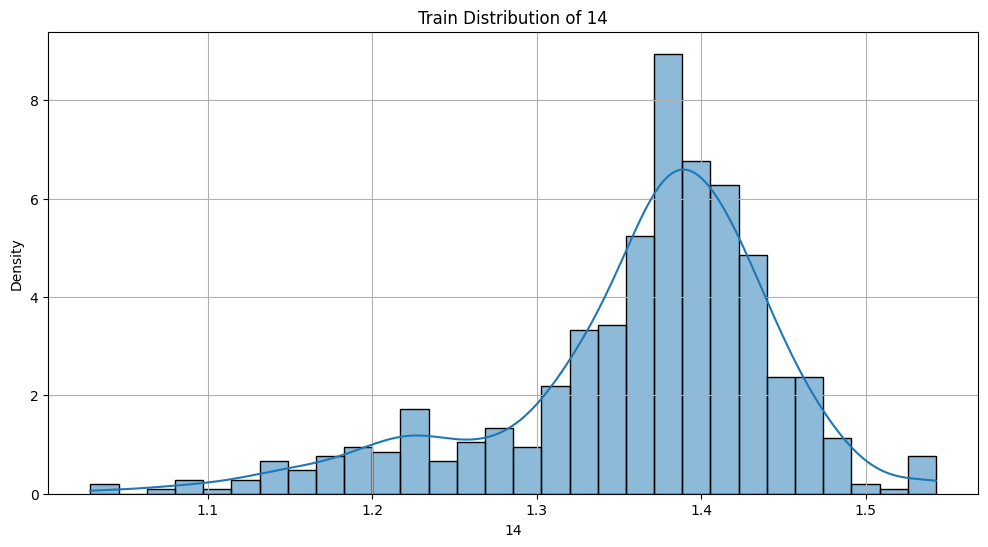

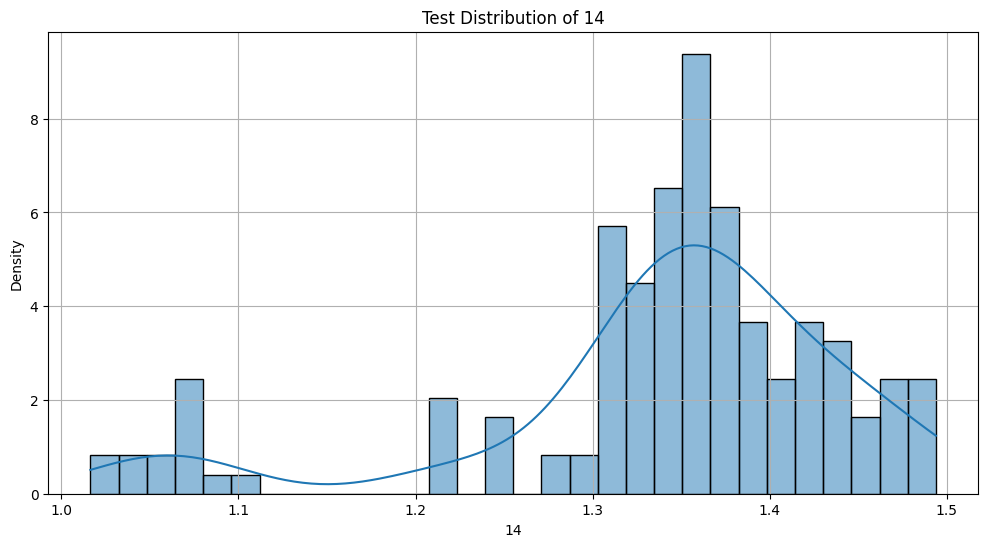

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_psi(expected, actual, buckettype='bins', buckets=10):
    if buckettype == 'bins':
        breakpoints = np.linspace(expected.min(), expected.max(), buckets + 1)
        expected_counts, _ = np.histogram(expected, bins=breakpoints)
        actual_counts, _ = np.histogram(actual, bins=breakpoints)
    else:
        raise ValueError("Unsupported bucket type")

    expected_proportions = expected_counts / expected_counts.sum()
    actual_proportions = actual_counts / actual_counts.sum()

    psi_value = np.sum((expected_proportions - actual_proportions) * np.log(expected_proportions / actual_proportions))
    return psi_value

def plot_feature_distribution(df, feature, title):
    plt.figure(figsize=(12, 6))
    sns.histplot(df[feature], kde=True, stat="density", bins=30)
    plt.title(title)
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.grid()
    plt.show()

for i in  [0,1,3,4,	5,	6,	7,	8,	9,	10,	11,	12,	13,	14]:
    psi_value = calculate_psi(train_df[i], test_df[i])
    print(f'PSI for {i}: {psi_value:.4f}')

    plot_feature_distribution(train_df, i, f'Train Distribution of {i}')
    plot_feature_distribution(test_df, i, f'Test Distribution of {i}')

##### Отбор признаков

In [22]:
train_df = train_df.drop(columns=[0, 1, 3, 4, 11])
test_df = test_df.drop(columns=[0, 1, 3, 4, 11])
train_df.head()

,2,5,6,7,8,9,10,12,13,14,target
0,,,,,,,,,,,
0,2023-06-15 03:30:00,2.429055,-0.334468,7.981222,-0.087364,0.002680,-2.786937e-15,0.369762,0.170905,1.379641,0.623
1,2023-06-15 05:30:00,2.481289,-0.951778,7.014456,-0.552718,0.001492,-1.297826e+00,0.231434,0.097160,1.379641,0.749
2,2023-06-15 08:30:00,1.078523,-1.110360,7.017953,0.194958,0.001901,-1.261372e+00,0.287297,0.095316,1.379641,0.567
3,2023-06-16 00:30:00,1.387313,-0.835319,7.358407,-0.361401,0.001742,-3.337860e-02,0.297938,0.104719,1.379641,0.868
4,2023-06-16 03:30:00,2.402651,-0.790659,7.511205,-0.304874,0.002402,-1.488056e+00,0.369762,0.115043,1.379641,0.714


##### Создание дополнительных статистических и лаговых признаков

In [ ]:

def preprocess_features(df, max_lags, window_sizes):
    
    df.rename(columns={2: 'date'}, inplace=True)
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)

    for lag in range(1, max_lags + 1):
        df[f'lag_{lag}'] = df['target'].shift(lag)
    df.dropna(inplace=True)
    
    # for window in window_sizes:
    #     df[f'rolling_mean_{window}'] = df['target'].rolling(window=window).mean()
    #     df[f'rolling_std_{window}'] = df['target'].rolling(window=window).std()
    #     df[f'rolling_max_{window}'] = df['target'].rolling(window=window).max()
    #     df[f'rolling_min_{window}'] = df['target'].rolling(window=window).min()
        
    return df


train_df_x = preprocess_features(train_df, 5, [5])
train_df_x.head(5)

,5,6,7,8,9,10,12,13,14,target,lag_1,lag_2,lag_3,lag_4,lag_5
date,,,,,,,,,,,,,,,
2023-06-16 05:30:00,2.486214,-0.935599,7.315273,-0.587990,0.004356,0.577218,0.404344,0.100478,1.379641,0.770,0.714,0.868,0.567,0.749,0.623
2023-06-16 08:30:00,2.476438,-0.934952,7.512617,-0.497816,0.004092,-0.452125,0.361782,0.106009,1.379641,0.770,0.770,0.714,0.868,0.567,0.749
2023-06-16 12:30:00,2.726013,-0.932443,7.441873,-0.844556,0.002917,-0.086983,0.438926,0.118177,1.379641,0.609,0.770,0.770,0.714,0.868,0.567
2023-06-16 15:30:00,2.450063,-0.947064,7.411019,-0.313713,0.002284,-0.112214,0.335180,0.144910,1.343869,0.602,0.609,0.770,0.770,0.714,0.868
2023-06-16 17:30:00,2.477296,-1.052227,6.707082,0.623021,0.002006,-0.949654,0.351141,0.165005,1.338443,0.630,0.602,0.609,0.770,0.770,0.714


In [ ]:
test_df.rename(columns={2: 'date'}, inplace=True)
test_df.set_index('date', inplace=True)
test_df.sort_index(inplace=True)
test_df

##### Save 

In [36]:
train_df.to_parquet('train_df.parquet')
test_df.to_parquet('test_df.parquet')

/home/krasarma/miniconda3/envs/polus-prepare/lib/python3.10/site-packages/pandas/io/parquet.py:190: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)
